# Flat Price Prediction - data scraped from Otodom.pl

I am going to create a model that will predict the estimated price for a flat in Poland with given parameters.<br>
The data was generated by me via scraping techniques on www.otodom.pl site.

# Data exploration

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [103]:
df = pd.read_csv("otodom_data_raw.csv", header=None, names=["Price", "Area", "Ownership", "Rooms", "Status", "Floor", "Balcony", "Terrace", "Garden", "Rent", "Garage", "BuildYear", "Lift", "City"])
df.head()

,Price,Area,Ownership,Rooms,Status,Floor,Balcony,Terrace,Garden,Rent,Garage,BuildYear,Lift,City
0,358000,43.68,building_ownership::full_ownership,2,construction_status-67::ready_to_use,floor_no::floor_2,0,0,0,236,extras_types-85::garage,1935,::n,szczecin
1,448500,35.88,building_ownership::full_ownership,2,construction_status::to_completion,floor_no::floor_1,1,0,0,-1,-1,2023,::y,kolobrzeg
2,999000,70.59,building_ownership::full_ownership,3,construction_status-67::ready_to_use,floor_no::floor_3,1,1,0,450,-1,2008,::y,kolobrzeg
3,409000,50.00,building_ownership::full_ownership,3,construction_status-67::ready_to_use,floor_no::ground_floor,0,1,0,-1,extras_types-85::garage,1935,::n,lomnica_16894
4,303900,34.03,building_ownership::full_ownership,2,construction_status::to_completion,floor_no::floor_1,1,0,0,-1,extras_types-85::garage,2023,::y,bydgoszcz


In [104]:
df.shape

(9986, 14)

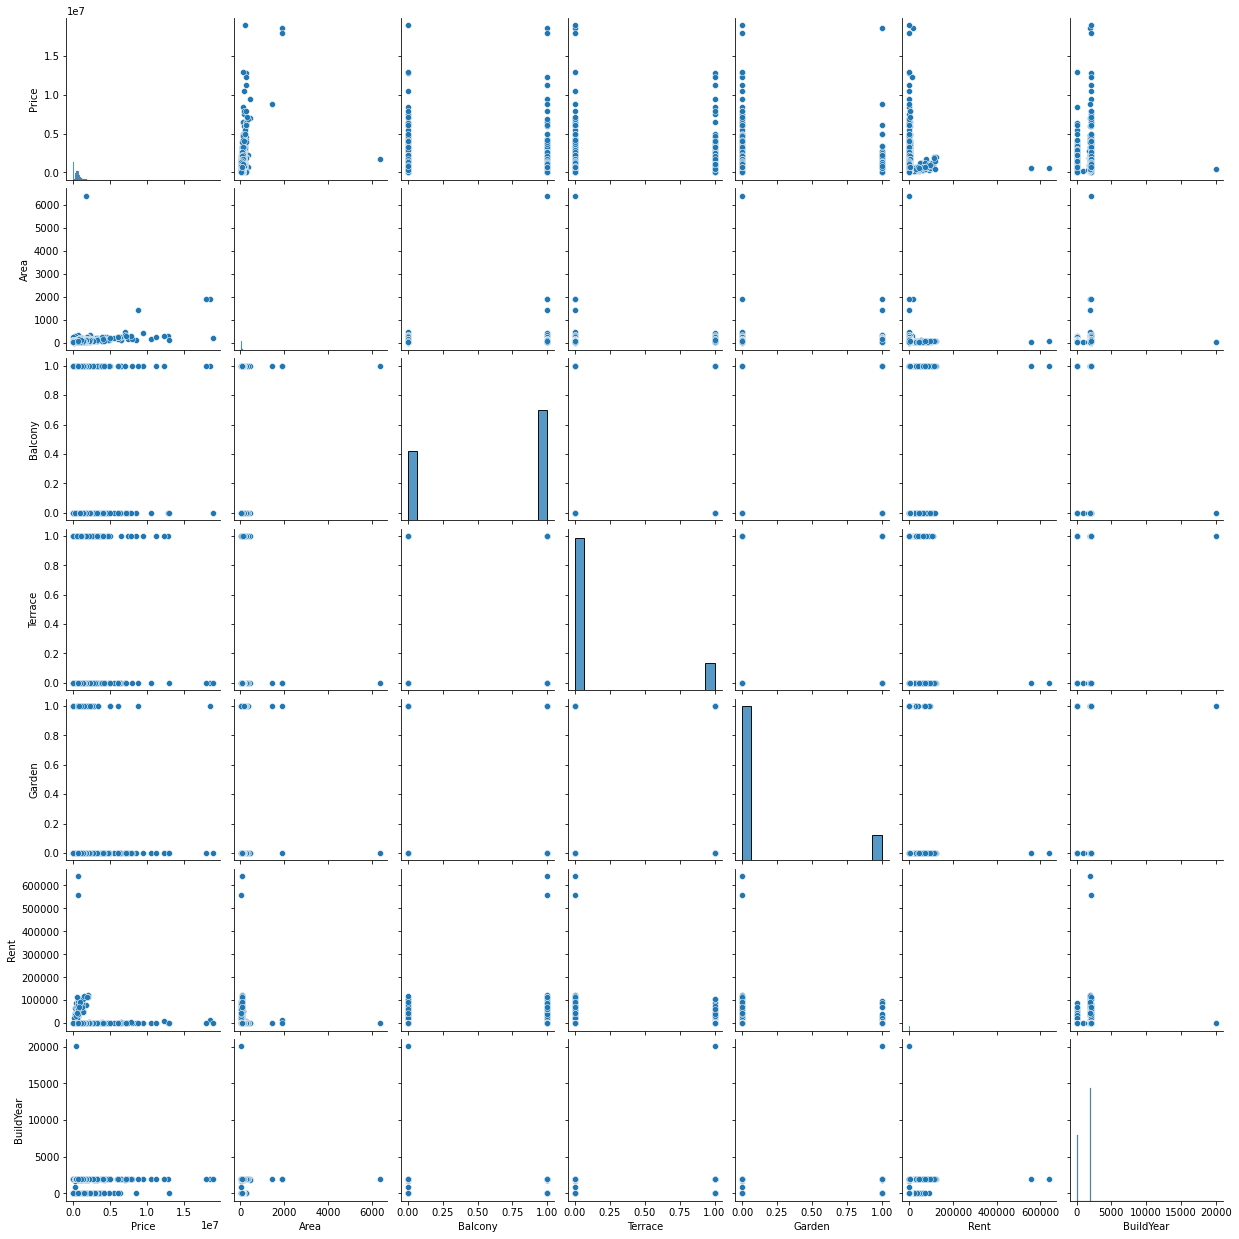

In [39]:
sns.pairplot(df)
plt.show()

In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9986 entries, 0 to 9985
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Price      9986 non-null   int64  
 1   Area       9986 non-null   float64
 2   Ownership  9986 non-null   object 
 3   Rooms      9986 non-null   object 
 4   Status     9986 non-null   object 
 5   Floor      9819 non-null   object 
 6   Balcony    9986 non-null   int64  
 7   Terrace    9986 non-null   int64  
 8   Garden     9986 non-null   int64  
 9   Rent       9986 non-null   int64  
 10  Garage     9986 non-null   object 
 11  BuildYear  9986 non-null   int64  
 12  Lift       9986 non-null   object 
 13  City       9986 non-null   object 
dtypes: float64(1), int64(6), object(7)
memory usage: 1.1+ MB


### Floor column

The missing values for the **Floor** column are hard to decide what to do with them. Usually the listings without given floor number are the listings for the whole building ( freshly built ), developers make just one advertisement and not for each single flat. I should consider either setting these values to 0 ( ground floor ) or deleting them. I can also find similiar rows and input the same **Floor** values. **I am going to replace with 0s**. I am also going to delete records with cellars and garrets, as they only take 1% of the whole dataset and they can potentially serve as noise.

In [106]:
df["Floor"].value_counts()

df["Floor"] = df["Floor"].str.replace("floor_no::", "")
df["Floor"] = df["Floor"].str.replace("ground_floor", "0")
df["Floor"] = df["Floor"].str.replace("floor_higher_10", "11")
df["Floor"] = df["Floor"].str.replace("floor_", "")
df["Floor"] = df["Floor"].str.replace("-1", "0")

df["Floor"].value_counts()

df1 = df[~df["Floor"].isin(["cellar", "garret"])]

df1["Floor"].value_counts()



1     2354
0     2086
2     1743
3     1427
4     1032
5      377
6      232
7      171
11     113
8       97
10      93
9       73
Name: Floor, dtype: int64

### Ownership column
Here I need to replace strings to natural ones, and I am going to replace -1 values as full_ownership, because when there is no info I guess someone just thought that it is obvious, that a flat is a "full_ownership"

In [247]:
df2 = df1.copy()
df2["Ownership"].unique()

df2.loc[:, "Ownership"] = df1["Ownership"].str.replace("building_ownership::", "")\
                                              .replace(["-1", "full_ownership"], "1")\
                                              .replace(["share", "usufruct", "limited_ownership"], "0")

df2["Ownership"].value_counts()

1    9527
0     438
Name: Ownership, dtype: int64

### Status column

In terms of **Status** column, there are too many -1 values, where the status of flat is not known. It is hard to guess the state, keeping on mind the number of missing values. I need to impute similiar row's values.

In [250]:
df2["Status"].value_counts()

df2.loc[:, "Status"] = df2["Status"].str.replace("construction_status::to_completion", "1").\
                                         replace("construction_status-67::ready_to_use", "2").\
                                         replace("construction_status::to_renovation", "0")
df2["Status"].value_counts()

2     3994
1     3705
-1    1653
0      613
Name: Status, dtype: int64

### Garage column

There is a simple choice, to state that missing values indicate no garage.

In [251]:
df2["Garage"].value_counts()

df2.loc[:, "Garage"] = df2["Garage"].str.replace("extras_types-85::garage", "1").replace("-1", "0")

df2["Garage"].value_counts()

1    5580
0    4385
Name: Garage, dtype: int64

### BuildYear column

I am going to get rid of incorrect values ex. "94".
I need to inpute similiar values in terms of missing values, because I cannot find a pattern to do it manually.

In [260]:
df2["BuildYear"].unique()
df3 = df2[( (df2["BuildYear"] > 1000) | (df2["BuildYear"] == -1) ) & (df2["BuildYear"] <= 2024)]


df3["BuildYear"].unique()

array([1935, 2023, 2008,   -1, 2021, 1979, 1966, 2015, 1990, 2014, 2013,
       1992, 2024, 1900, 1996, 2018, 1997, 1917, 2022, 1972, 2010, 1930,
       2005, 2000, 1956, 1902, 1980, 1977, 2017, 1965, 1988, 2019, 2016,
       2009, 1925, 1940, 1969, 1952, 1960, 1955, 1973, 1920, 1975, 1970,
       2011, 1985, 1934, 1982, 1959, 1976, 1995, 1986, 1950, 2001, 1983,
       1929, 1910, 1962, 1870, 1926, 1993, 1936, 2007, 2020, 1961, 2006,
       1905, 1912, 1984, 1974, 1989, 1964, 2012, 1903, 1958, 1909, 2002,
       2004, 1967, 1908, 1968, 1981, 1886, 2003, 1938, 1998, 1895, 1907,
       1939, 1919, 1971, 1932, 1927, 1987, 1978, 1994, 1890, 1944, 1937,
       1906, 1963, 1889, 1999, 1953, 1957, 1911, 1913, 1901, 1933, 1954,
       1947, 1904, 1897, 1931, 1991, 1880, 1893, 1868, 1928, 1915, 1914,
       1948, 1951, 1923, 1845, 1945, 1878, 1800, 1918, 1869, 1896, 1660,
       1949], dtype=int64)

### Lift column

Simply replace missing values with **0s**.

In [261]:
df4 = df3.copy()

df4["Lift"].value_counts()

df4.loc[:, "Lift"] = df3["Lift"].str.replace("::y", "1").replace(["::n", "-1"], "0")
df4["Lift"].value_counts()

0    6058
1    3449
Name: Lift, dtype: int64

In [262]:
df4.head()

,Price,Area,Ownership,Rooms,Status,Floor,Balcony,Terrace,Garden,Rent,Garage,BuildYear,Lift,City
0,358000,43.68,1,2,2,2,0,0,0,236,1,1935,0,szczecin
1,448500,35.88,1,2,1,1,1,0,0,-1,0,2023,1,kolobrzeg
2,999000,70.59,1,3,2,3,1,1,0,450,0,2008,1,kolobrzeg
3,409000,50.00,1,3,2,0,0,1,0,-1,1,1935,0,lomnica_16894
4,303900,34.03,1,2,1,1,1,0,0,-1,1,2023,1,bydgoszcz


### City column

I picked the cities, where prices of the flats are especially high. I classified them as **Metropolies**. The rest is labeled as **Others**.

In [271]:
df5 = df4.copy()
#df5[df5["City"] == "gorlice"]

RICH_CITIES = [
    "warszawa", "krakow", "lodz", "wroclaw",
    "poznan", "gdansk", "szczecin", "bydgoszcz",
    "lublin", "bialystok", "katowice", "rzeszow",
    "torun", "kielce", "olsztyn", "opole", "gdynia",
    "mielno", "sopot", "miedzyzdroje", "zakopane",
    "swinoujscie", "kolobrzeg", "koscielisko"
]

df5.loc[df5["City"].isin(RICH_CITIES), "City"] = "1"
#df5["Price/Area"] = df5["Price"] / df5["Area"]
#df5[df5["City"] != "Metropoly"].sort_values("Price/Area", ascending=False).head(40)

df5.loc[df5["City"] != "1", "City"] = "0"

df5["City"].value_counts()

1    6421
0    3086
Name: City, dtype: int64

### Rooms column

There is not a lot of flats with **"rooms_num::more"** flag. I decided to delete it as the price range is wide for records with this value in "Rooms" column. They were simply outliers.

In [272]:
df5["Rooms"].unique()

df5 = df5[df5["Rooms"] != "rooms_num::more"]

df5["Rooms"].value_counts()

2     3562
3     3391
4     1302
1      954
5      226
6       44
7        9
8        6
10       2
9        2
Name: Rooms, dtype: int64

## Columns still with missing values

- **Status**
- **BuildYear**
- **Price**<br>
I am going to treat these rows with KNNImputer

In [273]:
from sklearn.impute import KNNImputer

I have decided to get rid of **Rent** feature. It has more than 50% of missing values. Moresoever It does not play a significant role in price prediction.

In [274]:
df5 = df5.replace(-1, np.nan)
df5.isna().sum()

Price         945
Area            0
Ownership       0
Rooms           0
Status          0
Floor         155
Balcony         0
Terrace         0
Garden          0
Rent         5060
Garage          0
BuildYear    3677
Lift            0
City            0
dtype: int64

In [275]:
df6 = df5.drop("Rent", axis=1)
df6.head()

,Price,Area,Ownership,Rooms,Status,Floor,Balcony,Terrace,Garden,Garage,BuildYear,Lift,City
0,358000.0,43.68,1,2,2,2,0,0,0,1,1935.0,0,1
1,448500.0,35.88,1,2,1,1,1,0,0,0,2023.0,1,1
2,999000.0,70.59,1,3,2,3,1,1,0,0,2008.0,1,1
3,409000.0,50.00,1,3,2,0,0,1,0,1,1935.0,0,0
4,303900.0,34.03,1,2,1,1,1,0,0,1,2023.0,1,1


In [285]:
imputer = KNNImputer(n_neighbors=10)
data_clean = imputer.fit_transform(df6)

In [286]:
data_clean

array([[3.580000e+05, 4.368000e+01, 1.000000e+00, ..., 1.935000e+03,
        0.000000e+00, 1.000000e+00],
       [4.485000e+05, 3.588000e+01, 1.000000e+00, ..., 2.023000e+03,
        1.000000e+00, 1.000000e+00],
       [9.990000e+05, 7.059000e+01, 1.000000e+00, ..., 2.008000e+03,
        1.000000e+00, 1.000000e+00],
       ...,
       [1.031116e+06, 1.393400e+02, 1.000000e+00, ..., 2.023000e+03,
        0.000000e+00, 1.000000e+00],
       [6.330000e+05, 5.202000e+01, 1.000000e+00, ..., 2.023700e+03,
        0.000000e+00, 1.000000e+00],
       [6.500000e+05, 5.662000e+01, 1.000000e+00, ..., 2.023000e+03,
        1.000000e+00, 1.000000e+00]])

In [287]:
df_clean = pd.DataFrame(data_clean, columns=["Price", "Area", "Ownership", "Rooms", "Status", "Floor", "Balcony", "Terrace", "Garden", "Garage", "BuildYear", "Lift", "City"])

df_clean.head()

,Price,Area,Ownership,Rooms,Status,Floor,Balcony,Terrace,Garden,Garage,BuildYear,Lift,City
0,358000.0,43.68,1.0,2.0,2.0,2.0,0.0,0.0,0.0,1.0,1935.0,0.0,1.0
1,448500.0,35.88,1.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,2023.0,1.0,1.0
2,999000.0,70.59,1.0,3.0,2.0,3.0,1.0,1.0,0.0,0.0,2008.0,1.0,1.0
3,409000.0,50.00,1.0,3.0,2.0,0.0,0.0,1.0,0.0,1.0,1935.0,0.0,0.0
4,303900.0,34.03,1.0,2.0,1.0,1.0,1.0,0.0,0.0,1.0,2023.0,1.0,1.0


In [288]:
df_clean.isna().sum()

Price        0
Area         0
Ownership    0
Rooms        0
Status       0
Floor        0
Balcony      0
Terrace      0
Garden       0
Garage       0
BuildYear    0
Lift         0
City         0
dtype: int64

In [290]:
df_clean.shape

(9498, 13)

In [292]:
df_clean.describe()

,Price,Area,Ownership,Rooms,Status,Floor,Balcony,Terrace,Garden,Garage,BuildYear,Lift,City
count,9.498000e+03,9498.000000,9498.000000,9498.000000,9498.000000,9498.000000,9498.000000,9498.000000,9498.000000,9498.000000,9498.000000,9498.000000,9498.000000
mean,7.079585e+05,58.809433,0.954622,2.632344,1.022215,2.289829,0.614866,0.147399,0.137081,0.551695,2004.616361,0.362813,0.675405
std,6.155423e+05,70.056627,0.208143,0.982105,1.069862,2.231024,0.486653,0.354522,0.343951,0.497347,27.310111,0.480837,0.468248
min,2.000000e+04,11.000000,0.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1660.000000,0.000000,0.000000
25%,4.150075e+05,42.000000,1.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1997.000000,0.000000,0.000000
50%,5.950000e+05,53.500000,1.000000,3.000000,1.000000,2.000000,1.000000,0.000000,0.000000,1.000000,2016.850000,0.000000,1.000000
75%,7.990000e+05,67.267500,1.000000,3.000000,2.000000,3.000000,1.000000,0.000000,0.000000,1.000000,2023.000000,1.000000,1.000000
max,1.900000e+07,6394.000000,1.000000,10.000000,2.000000,11.000000,1.000000,1.000000,1.000000,1.000000,2024.000000,1.000000,1.000000


# Model creation